In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='e5b01316-4ee6-41d1-b961-83a5eecef45b', project_access_token='p-41f2c4a2b569a23024dc0aac835f026f7eef9ad8')
pc = project.project_context


In [2]:
! pip install folium
import types
import folium
import pandas as pd
from botocore.client import Config
import ibm_boto3
import requests
from sklearn.cluster import KMeans
import json
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_83cd9ed001264fe3bb603472207cee4b = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='0L-vSTlqpjvk2-QVDWMulrZC7yW7XS7fQZPQ20yvy_c3',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_83cd9ed001264fe3bb603472207cee4b.get_object(Bucket='finalproject-donotdelete-pr-vvq5s5ehmw974s',Key='district.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

districts = pd.read_csv(body)
districts.head()

     |████████████████████████████████| 102kB 470kB/s ta 0:00:011


,State,District,Tehsil,Tehsil Name( LL)
0,Delhi,North West *,Narela,Narela
1,Delhi,North *,Civil Lines,Civil Lines
2,Delhi,North East *,Seelam Pur,Seelam Pur
3,Delhi,East *,Gandhi Nagar,Gandhi Nagar
4,Delhi,New Delhi,Parliament Street,Parliament Street


In [3]:
districts.drop('Tehsil Name( LL)',axis=1,inplace=True)
districts['Address']=(districts['Tehsil'].map(str)+','+districts['State'].map(str))

In [4]:
districts.head()

,State,District,Tehsil,Address
0,Delhi,North West *,Narela,"Narela,Delhi"
1,Delhi,North *,Civil Lines,"Civil Lines,Delhi"
2,Delhi,North East *,Seelam Pur,"Seelam Pur,Delhi"
3,Delhi,East *,Gandhi Nagar,"Gandhi Nagar,Delhi"
4,Delhi,New Delhi,Parliament Street,"Parliament Street,Delhi"


In [5]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="india")

In [6]:
LatLng=[]
for address in districts.Address:
        g = geolocator.geocode(address)
        if g is None:
            print('{} could not be geocoded'.format(address))
        else:
            print(address)
            LatLng.append((address, g.latitude, g.longitude))

Narela,Delhi
Civil Lines,Delhi
Seelam Pur,Delhi
Gandhi Nagar,Delhi
Parliament Street,Delhi
Karol Bagh,Delhi
Punjabi Bagh,Delhi
Najafgarh,Delhi
Defence Colony,Delhi
Hauz Khas,Delhi
Delhi Cantonment.,Delhi
Patel Nagar,Delhi
Pahar Ganj,Delhi
Connaught Place,Delhi
Vivek Vihar,Delhi
Shahdara,Delhi
Sadar Bazar,Delhi
Saraswati Vihar,Delhi
Model Town,Delhi
Kotwali,Delhi
Seema Puri,Delhi
Preet Vihar,Delhi
Chanakya Puri,Delhi
Darya Ganj,Delhi could not be geocoded
Rajouri Garden,Delhi
Vasant Vihar,Delhi
Kalkaji,Delhi
Shaikpet,Telangana
Ameerpet,Telangana
Secunderabad,Telangana
Tirumalagiri,Telangana
Maredpalle,Telangana could not be geocoded
Musheerabad,Telangana
Amberpet,Telangana
Himayathnagar,Telangana
Nampally,Telangana
Khairatabad,Telangana
Asifnagar,Telangana
Golconda,Telangana
Bahadurpura,Telangana
Bandlaguda,Telangana
Charminar,Telangana
Saidabad,Telangana
Bangalore North,Karnataka
Bangalore South,Karnataka
Anekal,Karnataka
Bangalore East,Karnataka
Nelamangala,Karnataka
Doddaballapura,Ka

In [7]:
LatLng=pd.DataFrame(data=LatLng,columns=['Address','Latitude','Longitude'])
LatLng.head()

,Address,Latitude,Longitude
0,"Narela,Delhi",28.842610,77.091835
1,"Civil Lines,Delhi",28.676851,77.225030
2,"Seelam Pur,Delhi",28.685543,77.261592
3,"Gandhi Nagar,Delhi",28.453175,77.015329
4,"Parliament Street,Delhi",28.617188,77.207808


In [8]:
districts=districts.merge(LatLng,how='inner')
districts.head(10)

,State,District,Tehsil,Address,Latitude,Longitude
0,Delhi,North West *,Narela,"Narela,Delhi",28.842610,77.091835
1,Delhi,North *,Civil Lines,"Civil Lines,Delhi",28.676851,77.225030
2,Delhi,North East *,Seelam Pur,"Seelam Pur,Delhi",28.685543,77.261592
3,Delhi,East *,Gandhi Nagar,"Gandhi Nagar,Delhi",28.453175,77.015329
4,Delhi,New Delhi,Parliament Street,"Parliament Street,Delhi",28.617188,77.207808
5,Delhi,Central *,Karol Bagh,"Karol Bagh,Delhi",28.652998,77.189023
6,Delhi,West *,Punjabi Bagh,"Punjabi Bagh,Delhi",28.668945,77.132461
7,Delhi,South West *,Najafgarh,"Najafgarh,Delhi",28.612304,76.982391
8,Delhi,South *,Defence Colony,"Defence Colony,Delhi",28.571222,77.231776
9,Delhi,South *,Hauz Khas,"Hauz Khas,Delhi",28.544256,77.206707


In [9]:
i=geolocator.geocode('India')
map_India = folium.Map(location=[i.latitude, i.longitude], zoom_start=4.5)
for lat, lng, district, tehsil, state in zip(districts['Latitude'], districts['Longitude'], districts['District'], districts['Tehsil'], districts['State']):
    label = '{}, {}, {}'.format(tehsil, district, state)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_India)  
    
map_India

In [10]:
CLIENT_ID = 'M4J1ULQCTBAARW1CHRL4LOSOU5OFG02MJRPQRNLTGRM02UP2' # your Foursquare ID
CLIENT_SECRET = 'B221FKTWRZIUAO5VLBO5HURLKAU42K0YIDXBQRJT4PXTBZ3W' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 
radius = 5000
categoryId='4d4b7105d754a06374d81259'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: M4J1ULQCTBAARW1CHRL4LOSOU5OFG02MJRPQRNLTGRM02UP2
CLIENT_SECRET:B221FKTWRZIUAO5VLBO5HURLKAU42K0YIDXBQRJT4PXTBZ3W


In [11]:
LIMIT = 100 
radius = 15000
categoryId='4d4b7105d754a06374d81259'

def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Tehsil', 
                  'Tehsil Latitude', 
                  'Tehsil Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
district_venues = getNearbyVenues(names=districts['Tehsil'],
                                   latitudes=districts['Latitude'],
                                   longitudes=districts['Longitude'])

Narela
Civil Lines
Seelam Pur
Gandhi Nagar
Parliament Street
Karol Bagh
Punjabi Bagh
Najafgarh
Defence Colony
Hauz Khas
Delhi Cantonment.
Patel Nagar
Pahar Ganj
Connaught Place
Vivek Vihar
Shahdara
Sadar Bazar
Saraswati Vihar
Model Town
Kotwali
Seema Puri
Preet Vihar
Chanakya Puri
Rajouri Garden
Vasant Vihar
Kalkaji
Shaikpet
Ameerpet
Secunderabad
Tirumalagiri
Musheerabad
Amberpet
Himayathnagar
Nampally
Khairatabad
Asifnagar
Golconda
Bahadurpura
Bandlaguda
Charminar
Saidabad
Bangalore North
Bangalore South
Anekal
Bangalore East
Nelamangala
Doddaballapura
Devanahalli
Hoskote
Junnar
Ambegaon
Shirur
Khed
Mawal
Mulshi
Haveli
Pune City
Daund
Purandhar
Velhe
Bhor
Baramati
Indapur
Talasari
Dahanu
Vikramgad
Jawhar
Mokhada
Vada
Palghar
Vasai
Thane
Bhiwandi
Shahapur
Kalyan
Ulhasnagar
Ambarnath
Murbad
Kurla
Andheri
Kolkata
Ladpura
Ramganj Mandi
Sangod
Pipalda
Digod
Chandigarh
Jaipur
Sanganer
Amber
Kotputli
Chomu
Jamwa Ramgarh
Bassi
Shahpura
Chaksu
Mauzamabad
Phagi
Viratnagar
Alandur
Aminjikarai
Am

In [13]:
district_venues.head()

,Tehsil,Tehsil Latitude,Tehsil Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Narela,28.84261,77.091835,Costa Coffee,28.725949,77.144286,Café
1,Narela,28.84261,77.091835,Domino's Pizza,28.737316,77.130891,Pizza Place
2,Narela,28.84261,77.091835,Domino's Pizza,28.736000,77.113000,Pizza Place
3,Narela,28.84261,77.091835,McDonald's,28.724240,77.113153,Fast Food Restaurant
4,Narela,28.84261,77.091835,CCD prashant vihar,28.712517,77.129244,Café


In [14]:
# one hot encoding
district_final = pd.get_dummies(district_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
district_final['Tehsil'] = district_venues['Tehsil'] 

# move neighborhood column to the first column
fixed_columns = [district_final.columns[-1]] + list(district_final.columns[:-1])
district_final = district_final[fixed_columns]

district_final.head()

,Tehsil,Afghan Restaurant,African Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Australian Restaurant,Awadhi Restaurant,BBQ Joint,Bagel Shop,...,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,Narela,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Narela,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Narela,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Narela,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Narela,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [16]:
district_grouped = district_final.groupby('Tehsil').mean().reset_index()
district_grouped

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Tehsil']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
tehsil_venues_sorted = pd.DataFrame(columns=columns)
tehsil_venues_sorted['Tehsil'] = district_grouped['Tehsil']

for ind in np.arange(district_grouped.shape[0]):
    tehsil_venues_sorted.iloc[ind, 1:] = return_most_common_venues(district_grouped.iloc[ind, :], num_top_venues)

tehsil_venues_sorted.head()

,Tehsil,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ahmedabad City,Indian Restaurant,Café,Fast Food Restaurant,Restaurant,Sandwich Place,Vegetarian / Vegan Restaurant,BBQ Joint,Diner,Pizza Place,Snack Place
1,Alandur,Indian Restaurant,Italian Restaurant,Sandwich Place,Café,BBQ Joint,South Indian Restaurant,Pizza Place,Chinese Restaurant,Donut Shop,Fast Food Restaurant
2,Allahabad,Pizza Place,Fast Food Restaurant,Café,Restaurant,Vegetarian / Vegan Restaurant,English Restaurant,Deli / Bodega,Dhaba,Diner,Doner Restaurant
3,Ambarnath,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Pizza Place,Breakfast Spot,Falafel Restaurant,Dhaba,Diner,Doner Restaurant,Donut Shop
4,Ambattur,Indian Restaurant,Café,Fast Food Restaurant,Italian Restaurant,BBQ Joint,Snack Place,Restaurant,Sandwich Place,South Indian Restaurant,Breakfast Spot


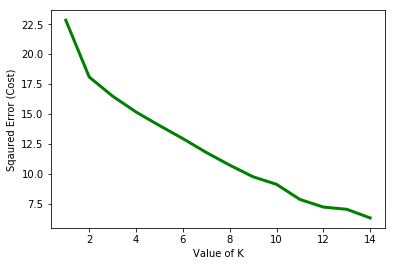

In [17]:
district_grouped_clustering = district_grouped.drop('Tehsil', 1)
cost =[] 
for b in range(1, 15): 
    KM = KMeans(n_clusters = b, max_iter = 500) 
    KM.fit(district_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 15), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

In [18]:
# set number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(district_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int32)

In [19]:
tehsil_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
districts_merged=districts
districts_merged = districts_merged.join(tehsil_venues_sorted.set_index('Tehsil'), on='Tehsil')
districts_merged.head() # check the last columns!

,State,District,Tehsil,Address,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Delhi,North West *,Narela,"Narela,Delhi",28.842610,77.091835,1.0,Fast Food Restaurant,Indian Restaurant,Pizza Place,Café,Bakery,Vegetarian / Vegan Restaurant,Falafel Restaurant,Dhaba,Diner,Doner Restaurant
1,Delhi,North *,Civil Lines,"Civil Lines,Delhi",28.676851,77.225030,1.0,Indian Restaurant,Café,Bakery,Italian Restaurant,BBQ Joint,Restaurant,Chinese Restaurant,Mediterranean Restaurant,Snack Place,Japanese Restaurant
2,Delhi,North East *,Seelam Pur,"Seelam Pur,Delhi",28.685543,77.261592,1.0,Indian Restaurant,Café,Italian Restaurant,Bakery,BBQ Joint,Chinese Restaurant,Restaurant,Snack Place,Fast Food Restaurant,Asian Restaurant
3,Delhi,East *,Gandhi Nagar,"Gandhi Nagar,Delhi",28.453175,77.015329,1.0,Indian Restaurant,Café,Pizza Place,Fast Food Restaurant,Restaurant,Sandwich Place,American Restaurant,Italian Restaurant,Bakery,Asian Restaurant
4,Delhi,New Delhi,Parliament Street,"Parliament Street,Delhi",28.617188,77.207808,1.0,Indian Restaurant,Café,Italian Restaurant,Bakery,Asian Restaurant,Restaurant,South Indian Restaurant,Chinese Restaurant,French Restaurant,Mediterranean Restaurant


In [20]:
districts_merged.dropna(axis=0,inplace=True)

In [21]:
map_clusters = folium.Map(location=[i.latitude, i.longitude], zoom_start=4.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, tehsil, cluster in zip(districts_merged['Latitude'], districts_merged['Longitude'], districts_merged['Tehsil'], districts_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(tehsil) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [22]:
Cluster1=districts_merged.loc[districts_merged['Cluster Labels'] == 0, districts_merged.columns[[0]+[2] + list(range(4, districts_merged.shape[1]))]]
Cluster1.head()

,State,Tehsil,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Telangana,Tirumalagiri,16.722090,79.336361,0.0,Indian Restaurant,Fast Food Restaurant,Deli / Bodega,Dhaba,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,English Restaurant
49,Maharashtra,Junnar,19.200681,73.976819,0.0,Indian Restaurant,Snack Place,Dhaba,Vegetarian / Vegan Restaurant,Deli / Bodega,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
50,Maharashtra,Ambegaon,19.031694,73.950030,0.0,Indian Restaurant,Asian Restaurant,Fish & Chips Shop,Dhaba,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,English Restaurant
51,Maharashtra,Shirur,18.761099,74.209529,0.0,Indian Restaurant,Breakfast Spot,Food Court,Food,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Australian Restaurant,Awadhi Restaurant,Doner Restaurant,Donut Shop
52,Maharashtra,Khed,17.733492,73.436431,0.0,Indian Restaurant,Gluten-free Restaurant,Restaurant,Falafel Restaurant,Deli / Bodega,Dhaba,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant


In [23]:
Cluster2=districts_merged.loc[districts_merged['Cluster Labels'] == 1, districts_merged.columns[[0]+[2] + list(range(4, districts_merged.shape[1]))]]
Cluster2.head()

,State,Tehsil,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Delhi,Narela,28.842610,77.091835,1.0,Fast Food Restaurant,Indian Restaurant,Pizza Place,Café,Bakery,Vegetarian / Vegan Restaurant,Falafel Restaurant,Dhaba,Diner,Doner Restaurant
1,Delhi,Civil Lines,28.676851,77.225030,1.0,Indian Restaurant,Café,Bakery,Italian Restaurant,BBQ Joint,Restaurant,Chinese Restaurant,Mediterranean Restaurant,Snack Place,Japanese Restaurant
2,Delhi,Seelam Pur,28.685543,77.261592,1.0,Indian Restaurant,Café,Italian Restaurant,Bakery,BBQ Joint,Chinese Restaurant,Restaurant,Snack Place,Fast Food Restaurant,Asian Restaurant
3,Delhi,Gandhi Nagar,28.453175,77.015329,1.0,Indian Restaurant,Café,Pizza Place,Fast Food Restaurant,Restaurant,Sandwich Place,American Restaurant,Italian Restaurant,Bakery,Asian Restaurant
4,Delhi,Parliament Street,28.617188,77.207808,1.0,Indian Restaurant,Café,Italian Restaurant,Bakery,Asian Restaurant,Restaurant,South Indian Restaurant,Chinese Restaurant,French Restaurant,Mediterranean Restaurant


In [24]:
x=district_final.merge(districts[['Tehsil', 'State']], how='inner')

In [25]:
y=x.groupby('State').mean().T
y.head(10)

State,Chandigarh,Delhi,Gujarat,Haryana,Karnataka,Maharashtra,Punjab,Rajasthan,Tamil Nadu,Telangana,Uttar Pradesh,West Bengal
Afghan Restaurant,0.000000,0.000000,0.000000,0.000000,0.006073,0.002805,0.000000,0.000000,0.003566,0.000000,0.000000,0.000000
African Restaurant,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010699,0.000000,0.000000,0.000000
American Restaurant,0.044776,0.013611,0.010526,0.018634,0.018219,0.005610,0.000000,0.000000,0.001427,0.012214,0.000000,0.012821
Andhra Restaurant,0.000000,0.000000,0.000000,0.000000,0.010121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Asian Restaurant,0.000000,0.030424,0.005263,0.031056,0.020243,0.023843,0.007042,0.000000,0.022825,0.025191,0.000000,0.025641
Australian Restaurant,0.014925,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Awadhi Restaurant,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025641
BBQ Joint,0.014925,0.032026,0.047368,0.006211,0.016194,0.005610,0.000000,0.027933,0.045649,0.048855,0.012739,0.012821
Bagel Shop,0.000000,0.001201,0.000000,0.006211,0.000000,0.004208,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Bakery,0.104478,0.042834,0.021053,0.068323,0.046559,0.037868,0.021127,0.061453,0.013552,0.077099,0.063694,0.051282


In [26]:
Delhi=y['Delhi'].to_frame()
Delhi.columns=['Value']
Delhi['Value']=Delhi['Value']*Delhi.shape[0]
Delhi.sort_values(by='Value',ascending=False,inplace=True)
Delhi=Delhi.iloc[0:10,]

Karnataka=y['Karnataka'].to_frame()
Karnataka.columns=['Value']
Karnataka['Value']=Karnataka['Value']*Karnataka.shape[0]
Karnataka.sort_values(by='Value',ascending=False,inplace=True)
Karnataka=Karnataka.iloc[0:10,]

Maharashtra=y['Maharashtra'].to_frame()
Maharashtra.columns=['Value']
Maharashtra['Value']=Maharashtra['Value']*Maharashtra.shape[0]
Maharashtra.sort_values(by='Value',ascending=False,inplace=True)
Maharashtra=Maharashtra.iloc[0:10,]

Punjab=y['Punjab'].to_frame()
Punjab.columns=['Value']
Punjab['Value']=Punjab['Value']*Punjab.shape[0]
Punjab.sort_values(by='Value',ascending=False,inplace=True)
Punjab=Punjab.iloc[0:10,]

Rajasthan=y['Rajasthan'].to_frame()
Rajasthan.columns=['Value']
Rajasthan['Value']=Rajasthan['Value']*Rajasthan.shape[0]
Rajasthan.sort_values(by='Value',ascending=False,inplace=True)
Rajasthan=Rajasthan.iloc[0:10,]

TN=y['Tamil Nadu'].to_frame()
TN.columns=['Value']
TN['Value']=TN['Value']*TN.shape[0]
TN.sort_values(by='Value',ascending=False,inplace=True)
TN=TN.iloc[0:10,]

Telangana=y['Telangana'].to_frame()
Telangana.columns=['Value']
Telangana['Value']=Telangana['Value']*Telangana.shape[0]
Telangana.sort_values(by='Value',ascending=False,inplace=True)
Telangana=Telangana.iloc[0:10,]

UP=y['Uttar Pradesh'].to_frame()
UP.columns=['Value']
UP['Value']=UP['Value']*UP.shape[0]
UP.sort_values(by='Value',ascending=False,inplace=True)
UP=UP.iloc[0:10,]

Chandigarh=y['Chandigarh'].to_frame()
Chandigarh.columns=['Value']
Chandigarh['Value']=Chandigarh['Value']*Chandigarh.shape[0]
Chandigarh.sort_values(by='Value',ascending=False,inplace=True)
Chandigarh=Chandigarh.iloc[0:10,]

Kolkata=y['West Bengal'].to_frame()
Kolkata.columns=['Value']
Kolkata['Value']=Kolkata['Value']*Kolkata.shape[0]
Kolkata.sort_values(by='Value',ascending=False,inplace=True)
Kolkata=Kolkata.iloc[0:10,]

Gujarat=y['Gujarat'].to_frame()
Gujarat.columns=['Value']
Gujarat['Value']=Gujarat['Value']*Gujarat.shape[0]
Gujarat.sort_values(by='Value',ascending=False,inplace=True)
Gujarat=Gujarat.iloc[0:10,]

WB=y['West Bengal'].to_frame()
WB.columns=['Value']
WB['Value']=WB['Value']*WB.shape[0]
WB.sort_values(by='Value',ascending=False,inplace=True)
WB=WB.iloc[0:10,]

Haryana=y['Haryana'].to_frame()
Haryana.columns=['Value']
Haryana['Value']=Haryana['Value']*Haryana.shape[0]
Haryana.sort_values(by='Value',ascending=False,inplace=True)
Haryana=Haryana.iloc[0:10,]

Text(0.5, 1.0, 'Telangana')

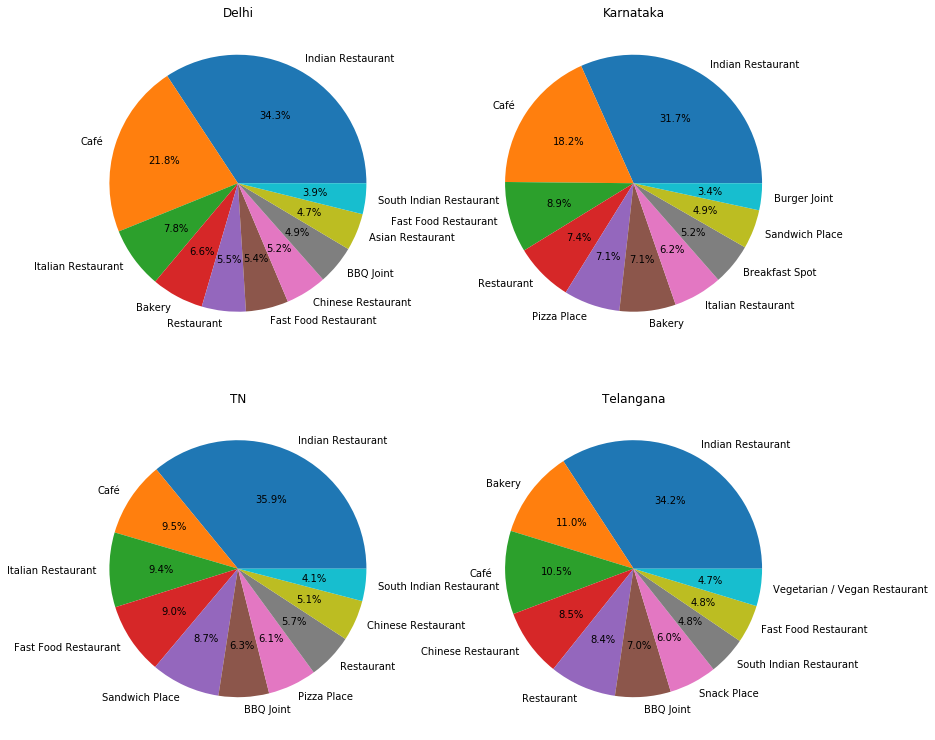

In [34]:
f1=plt.figure(figsize=(13,13))
ax1=f1.add_subplot(221)
ax1.pie(Delhi['Value'],autopct='%1.1f%%',labels=Delhi.index)
ax1.set_title('Delhi')
ax2=f1.add_subplot(222)
ax2.pie(Karnataka['Value'],autopct='%1.1f%%',labels=Karnataka.index)
ax2.set_title('Karnataka')
ax3=f1.add_subplot(223)
ax3.pie(TN['Value'],autopct='%1.1f%%',labels=TN.index)
ax3.set_title('TN')
ax4=f1.add_subplot(224)
ax4.pie(Telangana['Value'],autopct='%1.1f%%',labels=Telangana.index)
ax4.set_title('Telangana')

Text(0.5, 1.0, 'Chandigarh')

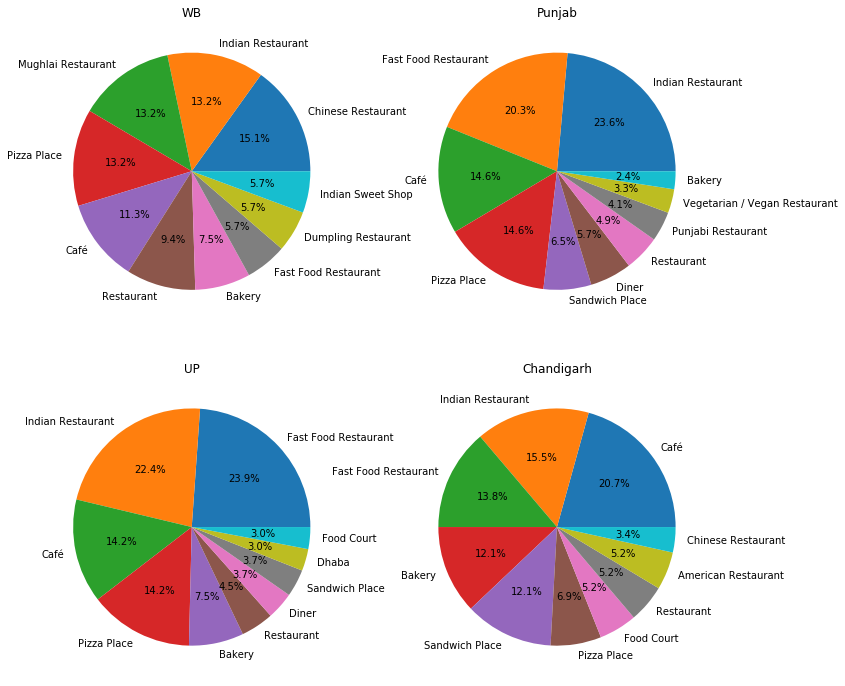

In [37]:
f2=plt.figure(figsize=(12,12))
ax5=f2.add_subplot(221)
ax5.pie(WB['Value'],autopct='%1.1f%%',labels=WB.index)
ax5.set_title('WB')
ax6=f2.add_subplot(222)
ax6.pie(Punjab['Value'],autopct='%1.1f%%',labels=Punjab.index)
ax6.set_title('Punjab')
ax7=f2.add_subplot(223)
ax7.pie(UP['Value'],autopct='%1.1f%%',labels=UP.index)
ax7.set_title('UP')
ax8=f2.add_subplot(224)
ax8.pie(Chandigarh['Value'],autopct='%1.1f%%',labels=Chandigarh.index)
ax8.set_title('Chandigarh')


Text(0.5, 1.0, 'Haryana')

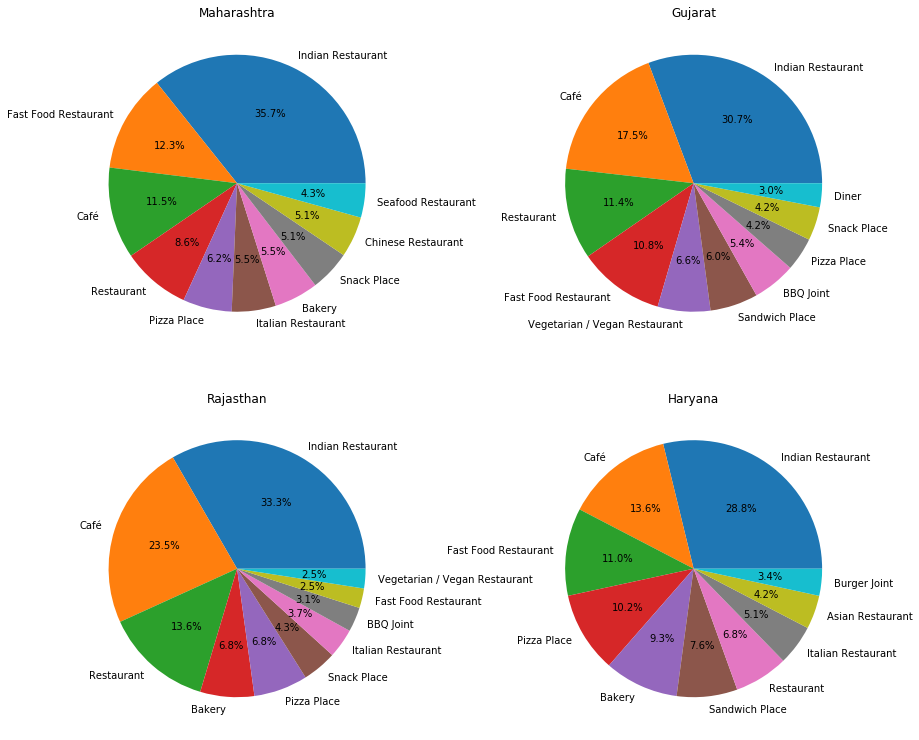

In [33]:
f3=plt.figure(figsize=(13,13))
ax9=f3.add_subplot(221)
ax9.pie(Maharashtra['Value'],autopct='%1.1f%%',labels=Maharashtra.index)
ax9.set_title('Maharashtra')
ax10=f3.add_subplot(222)
ax10.pie(Gujarat['Value'],autopct='%1.1f%%',labels=Gujarat.index)
ax10.set_title('Gujarat')
ax11=f3.add_subplot(223)
ax11.pie(Rajasthan['Value'],autopct='%1.1f%%',labels=Rajasthan.index)
ax11.set_title('Rajasthan')
ax11=f3.add_subplot(224)
ax11.pie(Haryana['Value'],autopct='%1.1f%%',labels=Haryana.index)
ax11.set_title('Haryana')


In [33]:
main=district_final.merge(districts_merged[['Tehsil','Cluster Labels']], how='inner')
main.head()

,Tehsil,Afghan Restaurant,African Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Australian Restaurant,Awadhi Restaurant,BBQ Joint,Bagel Shop,...,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Cluster Labels
0,Narela,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,Narela,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2,Narela,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
3,Narela,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4,Narela,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


In [34]:
clgraph=main.groupby('Cluster Labels').mean().T
clgraph.columns=['Cluster L0','Cluster L1']
clgraph.sort_values(['Cluster L0','Cluster L1'],ascending=False,inplace=True)
clgraph['Cluster L0']=((clgraph['Cluster L0']/sum(clgraph['Cluster L0']))*100).round(2)
clgraph['Cluster L1']=((clgraph['Cluster L1']/sum(clgraph['Cluster L1']))*100).round(2)
clgraph=clgraph.iloc[0:10,]

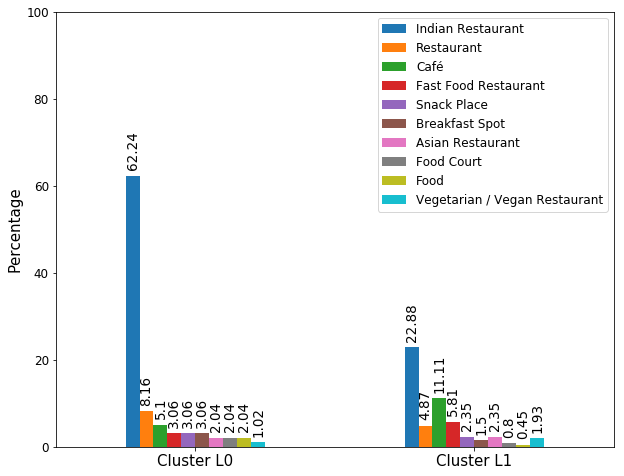

In [35]:
ax=clgraph.T.plot(kind='bar',figsize=(10,8))
for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,6), rotation=90, 
                   textcoords="offset points", ha="center", va="bottom",fontsize=13.5)

plt.ylim(0,100)
plt.ylabel('Percentage',fontsize=15)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [36]:
Cluster2['State'].mode()

0    Delhi
dtype: object

In [37]:
Cluster1['State'].mode()

0    Maharashtra
dtype: object

In [38]:
Cluster3['State'].mode()

Series([], dtype: object)

In [39]:
print('L0 rows={}'.format(Cluster1.shape[0]))

L0 rows=22


In [40]:
print('L1 rows={}'.format(Cluster2.shape[0]))

L1 rows=125


In [41]:
print('L2 rows={}'.format(Cluster3.shape[0]))

L2 rows=0


In [42]:
len(districts['State'].unique())

12

In [43]:
len(districts['District'].unique())

28

In [44]:
len(districts['Tehsil'].unique())

157

In [49]:
Cluster1[['Tehsil','State']]

,Tehsil,State
29,Tirumalagiri,Telangana
49,Junnar,Maharashtra
50,Ambegaon,Maharashtra
51,Shirur,Maharashtra
52,Khed,Maharashtra
57,Daund,Maharashtra
63,Talasari,Maharashtra
64,Dahanu,Maharashtra
65,Vikramgad,Maharashtra
77,Murbad,Maharashtra
